<a href="https://colab.research.google.com/github/bhargavaCharyRudravelli/Bhargava_INFO5731_Fall2024/blob/main/5731_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3 - Train Loss: 2.3716, Train Accuracy: 0.1959, Train F1: 0.1978, Val Loss: 2.1342, Val Accuracy: 0.3446, Val F1: 0.2712
Epoch 2/3 - Train Loss: 2.0412, Train Accuracy: 0.2905, Train F1: 0.2233, Val Loss: 1.8576, Val Accuracy: 0.5338, Val F1: 0.4658
Epoch 3/3 - Train Loss: 1.9365, Train Accuracy: 0.4459, Train F1: 0.3846, Val Loss: 1.8307, Val Accuracy: 0.5473, Val F1: 0.4774


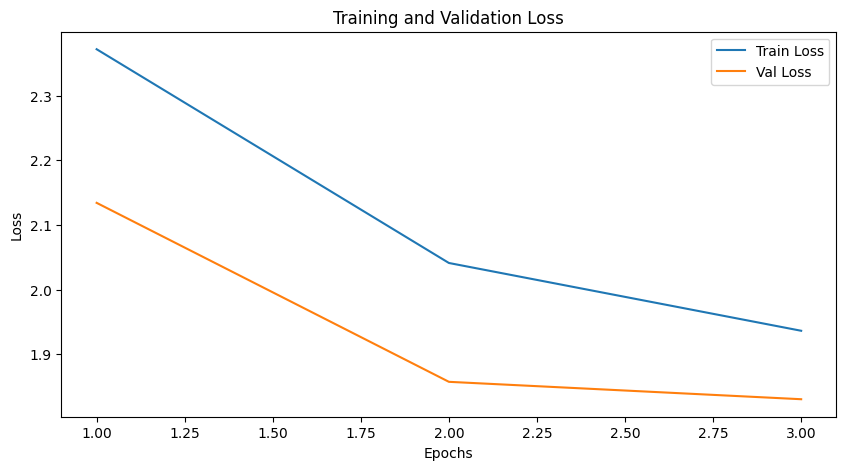

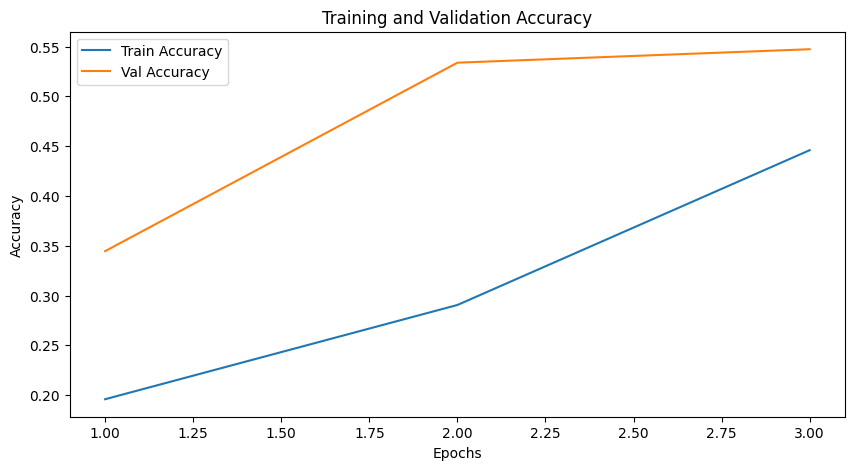

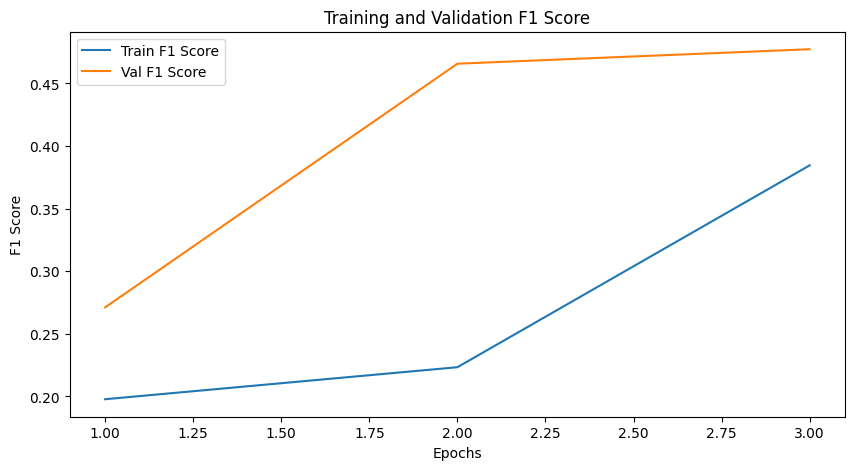

<ipython-input-2-5a2d03a14de4>:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabeled_data['cateorgy'] = [id_to_category[pred] for pred in predicted_labels]


In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Data Cleaning
# Drop rows with missing Main_Narrative or Narrative_Description
data = pd.read_excel('/content/sample_data/final dataset (1).xlsx', sheet_name='Disinformation stories')
data.head()
data_cleaned = data.dropna(subset=['Main_Narrative', 'Narrative_Description']).reset_index(drop=True)

# Separate labeled and unlabeled data
labeled_data = data_cleaned[data_cleaned['cateorgy'].notna()]
unlabeled_data = data_cleaned[data_cleaned['cateorgy'].isna()]

# Step 2: Prepare Data for BERT
PRETRAINED_MODEL = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL)

# Encode texts
def encode_texts(texts, max_length=128):
    encoded = tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt',
    )
    return encoded['input_ids'], encoded['attention_mask']

# Encode labeled data
labeled_texts = labeled_data['Narrative_Description'].tolist()
input_ids, attention_masks = encode_texts(labeled_texts)

# Map category labels to integers
categories = labeled_data['cateorgy'].unique()
category_to_id = {cat: idx for idx, cat in enumerate(categories)}
id_to_category = {idx: cat for cat, idx in category_to_id.items()}
labels = torch.tensor([category_to_id[cat] for cat in labeled_data['cateorgy']])

# Step 3: Load BERT Model for Fine-Tuning
N_LABELS = len(categories)
model = BertForSequenceClassification.from_pretrained(PRETRAINED_MODEL, num_labels=N_LABELS)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Step 4: Create DataLoader for Training
BATCH_SIZE = 16
dataset = TensorDataset(input_ids, attention_masks, labels)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Step 5: Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

# Step 6: Training and Validation Loop
EPOCHS = 3
train_loss_per_epoch = []
val_loss_per_epoch = []
train_accuracy_per_epoch = []
train_f1_per_epoch = []
val_accuracy_per_epoch = []
val_f1_per_epoch = []

# Train and evaluate each epoch
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    all_train_preds = []
    all_train_labels = []

    # Training Loop
    for batch in data_loader:
        b_input_ids, b_attention_mask, b_labels = [item.to(device) for item in batch]

        optimizer.zero_grad()
        outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_train_preds.extend(preds)
        all_train_labels.extend(b_labels.cpu().numpy())

        loss.backward()
        optimizer.step()

    # Calculate training accuracy and F1 score
    train_accuracy = accuracy_score(all_train_labels, all_train_preds)
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')

    # Validation Loop (on the same data for simplicity)
    model.eval()
    val_preds = []
    val_labels = []
    val_loss = 0

    with torch.no_grad():
        for batch in data_loader:
            b_input_ids, b_attention_mask, b_labels = [item.to(device) for item in batch]
            outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
            loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(b_labels.cpu().numpy())

    # Calculate validation accuracy and F1 score
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average='weighted')

    # Save metrics
    train_loss_per_epoch.append(total_loss / len(data_loader))
    val_loss_per_epoch.append(val_loss / len(data_loader))
    train_accuracy_per_epoch.append(train_accuracy)
    train_f1_per_epoch.append(train_f1)
    val_accuracy_per_epoch.append(val_accuracy)
    val_f1_per_epoch.append(val_f1)

    scheduler.step()

    print(f"Epoch {epoch + 1}/{EPOCHS} - Train Loss: {total_loss / len(data_loader):.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Train F1: {train_f1:.4f}, "
          f"Val Loss: {val_loss / len(data_loader):.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1: {val_f1:.4f}")

# Step 7: Plot Loss and Metrics
epochs_range = range(1, EPOCHS + 1)

# Plotting loss curve
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_loss_per_epoch, label="Train Loss")
plt.plot(epochs_range, val_loss_per_epoch, label="Val Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_accuracy_per_epoch, label="Train Accuracy")
plt.plot(epochs_range, val_accuracy_per_epoch, label="Val Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plotting F1 score curve
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_f1_per_epoch, label="Train F1 Score")
plt.plot(epochs_range, val_f1_per_epoch, label="Val F1 Score")
plt.title("Training and Validation F1 Score")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

# Step 8: Save the Model and Results
final_model_path = 'final_bert_model.pth'
torch.save(model.state_dict(), final_model_path)

# Save metrics to CSV for reference
metrics_df = pd.DataFrame({
    'Epoch': epochs_range,
    'Train Loss': train_loss_per_epoch,
    'Val Loss': val_loss_per_epoch,
    'Train Accuracy': train_accuracy_per_epoch,
    'Val Accuracy': val_accuracy_per_epoch,
    'Train F1': train_f1_per_epoch,
    'Val F1': val_f1_per_epoch
})
metrics_df.to_csv('training_metrics.csv', index=False)

# Step 9: Evaluate on Unlabeled Data
# Example for final evaluation (after model is trained)
unlabeled_texts = unlabeled_data['Narrative_Description'].tolist()
unlabeled_input_ids, unlabeled_attention_masks = encode_texts(unlabeled_texts)

unlabeled_dataset = TensorDataset(unlabeled_input_ids, unlabeled_attention_masks)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=BATCH_SIZE)

model.eval()
predictions = []
with torch.no_grad():
    for batch in unlabeled_loader:
        b_input_ids, b_attention_mask = [item.to(device) for item in batch]
        outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask)
        logits = outputs.logits
        predictions.append(torch.argmax(logits, dim=1).cpu().numpy())

predicted_labels = np.concatenate(predictions)
unlabeled_data['cateorgy'] = [id_to_category[pred] for pred in predicted_labels]

# Save the updated unlabeled data with predictions
unlabeled_data.to_excel('unlabeled_data_with_predictions.xlsx', index=False)
